# How to generate long-short trading signals with a Random Forest

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [4]:
sns.set_style('whitegrid')

In [5]:
np.random.seed(42)

In [6]:
YEAR = 252
idx = pd.IndexSlice

In [9]:
DATA_DIR = Path('data')

In [10]:
results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Get Data

See the notebook [japanese_equity_features](03_japanese_equity_features.ipynb) in this directory for data preparation.

In [12]:
data = pd.read_hdf('data/sector_data.h5', 'features_data')
data.index.set_names('date', level=1, inplace=True)
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 53874 entries, ('XLB', Timestamp('1998-12-22 00:00:00')) to ('XLY', Timestamp('2022-10-05 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ret_1            53865 non-null  float64
 1   ret_rel_perc_1   53865 non-null  float64
 2   ret_5            53829 non-null  float64
 3   ret_rel_perc_5   53829 non-null  float64
 4   ret_10           53784 non-null  float64
 5   ret_rel_perc_10  53784 non-null  float64
 6   ret_21           53685 non-null  float64
 7   ret_rel_perc_21  53685 non-null  float64
 8   ret_63           53307 non-null  float64
 9   ret_rel_perc_63  53307 non-null  float64
 10  PPO              53649 non-null  float64
 11  NATR             53748 non-null  float64
 12  RSI              53748 non-null  float64
 13  bbl              53838 non-null  float64
 14  bbu              53838 non-null  float64
 15  weekday          53874 non-n

We start with 941 tickers.

In [13]:
len(data.index.unique('ticker'))

9

## MultipleTimeSeriesCV

See [Chapter 7 - Linear Models](../07_linear_models) for details.

In [16]:
cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=126,
                          lookahead=5,
                          train_period_length=2 * 252)

For each fold, the train and test periods are separated by a `lookahead` number of periods and thus do not overlap:

In [17]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    msg = f'Training: {train_dates.min().date()}-{train_dates.max().date()} '
    msg += f' ({train.groupby(level="ticker").size().value_counts().index[0]:,.0f} days) | '
    msg += f'Test: {test_dates.min().date()}-{test_dates.max().date()} '
    msg += f'({test.groupby(level="ticker").size().value_counts().index[0]:,.0f} days)'
    print(msg)
    # if i == 3:
    #     break

Training: 2020-03-26-2022-03-30  (508 days) | Test: 2022-04-06-2022-10-05 (126 days)
Training: 2019-09-25-2021-09-29  (508 days) | Test: 2021-10-06-2022-04-05 (126 days)
Training: 2019-03-27-2021-03-31  (508 days) | Test: 2021-04-08-2021-10-05 (126 days)
Training: 2018-09-24-2020-09-29  (508 days) | Test: 2020-10-06-2021-04-07 (126 days)
Training: 2018-03-26-2020-03-31  (508 days) | Test: 2020-04-07-2020-10-05 (126 days)
Training: 2017-09-22-2019-09-30  (508 days) | Test: 2019-10-07-2020-04-06 (126 days)
Training: 2017-03-24-2019-04-01  (508 days) | Test: 2019-04-08-2019-10-04 (126 days)
Training: 2016-09-22-2018-09-27  (508 days) | Test: 2018-10-04-2019-04-05 (126 days)
Training: 2016-03-24-2018-03-29  (508 days) | Test: 2018-04-06-2018-10-03 (126 days)
Training: 2015-09-23-2017-09-27  (508 days) | Test: 2017-10-04-2018-04-05 (126 days)
Training: 2015-03-25-2017-03-29  (508 days) | Test: 2017-04-05-2017-10-03 (126 days)
Training: 2014-09-23-2016-09-27  (508 days) | Test: 2016-10-04-20

## Model Selection: Time Period and Horizon

For the model selection step, we restrict training and validation sets to the 1998-2012 period.

In [18]:
cv_data = data.loc[idx[:, :'2012'], :]
tickers = cv_data.index.unique('ticker')

Persist the data to save some time when running another experiment:

In [20]:
cv_data.to_hdf('data/sector_data.h5', 'cv_data')

In [22]:
with pd.HDFStore('data/sector_data.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/sector_data.h5
/cv_data                  frame        (shape->[31752,23])
/features_data            frame        (shape->[53874,23])


We're picking prediction horizons of 1, 5, 10 and 21 days:

In [23]:
lookaheads = [1, 5, 10, 21]

## Baseline: Linear Regression

Since it's quick to run and quite informative, we generate linear regression baseline predictions. See [Chapter 7 - Linear Models](../07_linear_models) for details.

In [24]:
lr = LinearRegression()

In [25]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

In [26]:
print(labels, features)

['fwd_ret_01', 'fwd_ret_05', 'fwd_ret_10', 'fwd_ret_21', 'fwd_ret_63'] ['NATR', 'PPO', 'RSI', 'bbl', 'bbu', 'month', 'ret_1', 'ret_10', 'ret_21', 'ret_5', 'ret_63', 'ret_rel_perc_1', 'ret_rel_perc_10', 'ret_rel_perc_21', 'ret_rel_perc_5', 'ret_rel_perc_63', 'weekday', 'year']


### CV Parameters

We set five different training lengths from 3 months to 5 years, and two test periods as follows:

In [29]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [63, 126]

Since linear regression has no hyperparameters, our CV parameters are the cartesian product of prediction horizon and train/test period lengths:

In [30]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

Now we iterate over these parameters and train/validate the linear regression model while capturing the information coefficient of the model predictions, measure both on a daily basis and for each complete fold:

In [31]:
lr_metrics = []
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'fwd_ret_{lookahead:02}'
    df = cv_data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(4 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████| 40/40 [00:18<00:00,  2.16it/s]


In [32]:
lr_metrics

,lookahead,train_length,test_length,ic_by_day,ic
0,1,1260,63,0.016918,-0.009529
1,1,1260,126,0.009145,-0.003852
2,1,756,63,0.011148,-0.015501
3,1,756,126,0.000583,-0.008390
4,1,252,63,0.042841,-0.011286
5,1,252,126,-0.002715,0.028980
6,1,126,63,0.070402,-0.006601
7,1,126,126,0.018701,0.017176
8,1,63,63,0.097338,0.018554
9,1,63,126,0.059861,0.029135


In [33]:
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB


### Information Coefficient distribution by Lookahead

Convert the data to long `seaborn`-friendly format:

In [34]:
lr_metrics_long = pd.concat([(lr_metrics.drop('ic', axis=1)
                              .rename(columns={'ic_by_day': 'ic'})
                              .assign(Measured='By Day')),
                             lr_metrics.drop('ic_by_day', axis=1)
                             .assign(Measured='Overall')])
lr_metrics_long.columns=['Lookahead', 'Train Length', 'Test Length', 'IC', 'Measure']
lr_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lookahead     80 non-null     int64  
 1   Train Length  80 non-null     int64  
 2   Test Length   80 non-null     int64  
 3   IC            80 non-null     float64
 4   Measure       80 non-null     object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ KB


Plot both IC measures for the various CV parameters:

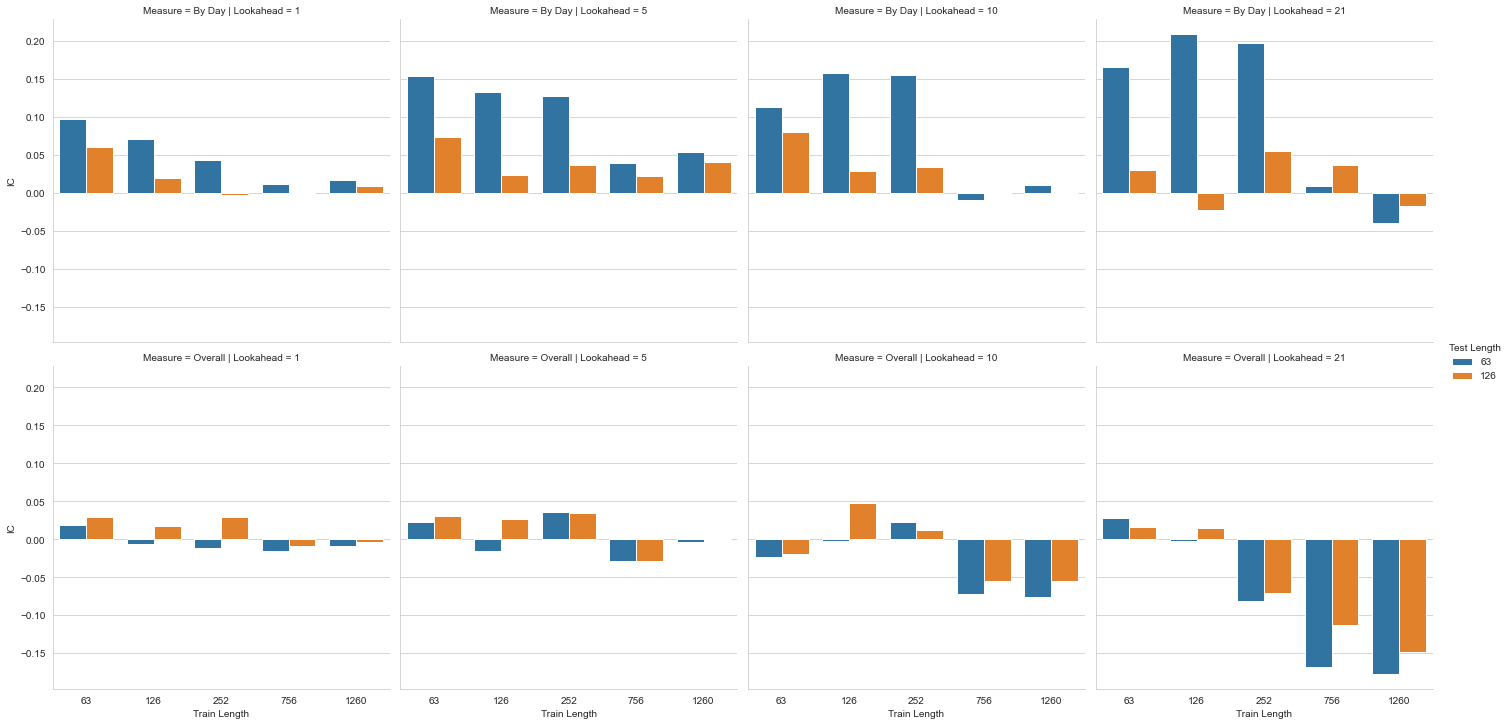

In [35]:
sns.catplot(x='Train Length',
            y='IC',
            hue='Test Length',
            col='Lookahead',
            row='Measure',
            data=lr_metrics_long,
            kind='bar')

Compare the distributions of each IC metric for the different prediction horizons:

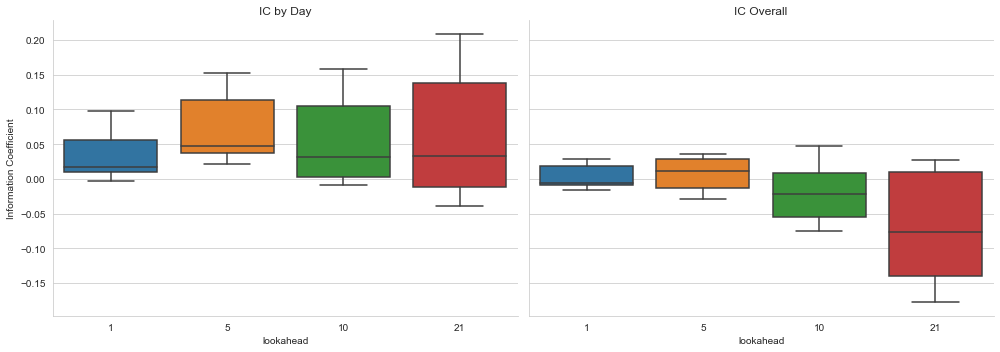

In [36]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
sns.despine()
fig.tight_layout()

### Best Train/Test Period Lengths

Show the best train/test period settings for the four prediction horizons:

In [38]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic
9,1,63,126,0.059861,0.029135
5,1,252,126,-0.002715,0.028980
8,1,63,63,0.097338,0.018554
14,5,252,63,0.127631,0.036162
15,5,252,126,0.036150,0.034478
19,5,63,126,0.073644,0.030261
27,10,126,126,0.029063,0.048106
24,10,252,63,0.155596,0.023316
25,10,252,126,0.034116,0.012742
38,21,63,63,0.165082,0.027403


In [39]:
lr_metrics.to_csv(results_path / 'sector_lin_reg_performance.csv', index=False)

## LightGBM Random Forest Model Tuning

Helper function to obtain the LightGBM feature importance metrics:

In [40]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

LightGBM base parameter settings that are independent of hyperparameter tuning:

In [41]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

### Hyperparameter Options

We run this experiment with different parameters for the bagging and feature fractions that determine the degree of randomization as well as the minimum number of samples for a split to control overfitting:

In [42]:
bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.75, .95]
# min_data_in_leaf_opts = [250, 500, 1000]
min_data_in_leaf_opts = [100, 250, 500]

This gives us 3x2x3=18 parameter combinations:

In [43]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

18

#### Random Sample

To limit the running time, we can randomly sample a subset of the parameter combinations (here: 50%):

In [44]:
sample_proportion = .5
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)), 
                                     size=int(sample_size), 
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 9


We tune the number of trees by evaluating a fully grown forest for various smaller sizes:

In [57]:
num_iterations = [25] + list(range(50, 501, 25))
num_boost_round = num_iterations[-1]

### Train/Test Period Lenghts

As above for linear regression, we define a range of train/test period length:

#### Define parameters

In [45]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [63, 126]

In [46]:
test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)

#### Random sample

Just as for the model parameters, we can randomly sample from the 5 x 2 = 8 training configurations (here: 50%):

In [48]:
sample_proportion = 0.5
sample_size = int(sample_proportion * n_test_params)

test_param_sample = np.random.choice(list(range(n_test_params)), 
                                     size=int(sample_size), 
                                     replace=False)
test_params_ = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params_))
print('CV Iterations:', len(cv_params_) * len(test_params_))

Train configs: 5
CV Iterations: 45


### Categorical Variables

To leverage LightGBM's ability to handle categorical variables, we need to define them; we'll also `factorize` them so they are both integer-encoded and start at zero (optional, but otherwise throws a warning) as expected by LightGBM:

In [52]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Run Cross-Validation

Set up some helper variabels and storage locations to faciliate the CV process and result storage:

In [53]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

In [54]:
label_dict = dict(zip(lookaheads, labels))

In [55]:
cv_store = Path(results_path / 'parameter_tuning.h5')

In [58]:
ic_cols = ['bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't'] + [str(n) for n in num_iterations]

Now we take the following steps:
- we iterate over the prediction horizons and train/test period length, 
- set up the `MultipleTimeSeriesCV` accordingly
- create the binary LightGBM dataset with the appropriate target, and
- iterate over the model hyperparamters to train and validate the model while capturing the relevant performance metrics:

In [59]:
for lookahead in lookaheads:
    for train_length, test_length in test_params_:
        n_splits = int(4 * YEAR / test_length)
        print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
              f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')

        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  train_period_length=train_length,
                                  lookahead=lookahead)

        label = label_dict[lookahead]
        outcome_data = data.loc[:, features + [label]].dropna()

        lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                               label=outcome_data[label],
                               categorical_feature=categoricals,
                               free_raw_data=False)
        predictions, daily_ic, ic, feature_importance = [], [], [], []
        key = f'{lookahead}/{train_length}/{test_length}'
        T = 0
        for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
            params = base_params.copy()
            params.update(dict(bagging_fraction=bagging_fraction,
                               feature_fraction=feature_fraction,
                               min_data_in_leaf=min_data_in_leaf))

            start = time()
            cv_preds, nrounds = [], []
            for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                lgb_train = lgb_data.subset(train_idx.tolist()).construct()
                
                lgb_train = lgb_data.subset(train_idx.tolist()).construct()
                lgb_test = lgb_data.subset(test_idx.tolist()).construct()

                model = lgb.train(params=params,
                                  train_set=lgb_train,
                                  num_boost_round=num_boost_round,
                                  verbose_eval=False)
                if i == 0:
                    fi = get_fi(model).to_frame()
                else:
                    fi[i] = get_fi(model)

                test_set = outcome_data.iloc[test_idx, :]
                X_test = test_set.loc[:, model.feature_name()]
                y_test = test_set.loc[:, label]
                y_pred = {str(n): model.predict(X_test, num_iteration=n)
                          for n in num_iterations}
                cv_preds.append(y_test.to_frame(
                    'y_test').assign(**y_pred).assign(i=i))
                nrounds.append(model.best_iteration)
            feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
                                                               feature_fraction=feature_fraction,
                                                               min_data_in_leaf=min_data_in_leaf))
            cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                                  feature_fraction=feature_fraction,
                                                  min_data_in_leaf=min_data_in_leaf)

            predictions.append(cv_preds)
            by_day = cv_preds.groupby(level='date')
            ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test,
                                                                    x[str(n)])[0]).to_frame(n)
                                   for n in num_iterations], axis=1)

            daily_ic.append(ic_by_day.assign(bagging_fraction=bagging_fraction,
                                             feature_fraction=feature_fraction,
                                             min_data_in_leaf=min_data_in_leaf))

            cv_ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
                  for n in num_iterations]

            T += time() - start
            ic.append([bagging_fraction, feature_fraction,
                       min_data_in_leaf, lookahead] + cv_ic)

            msg = f'{p:3.0f} | {format_time(T)} | '
            msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
            msg += f'{max(cv_ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {ic_by_day.median().max(): 6.2%}'
            print(msg)
        m = pd.DataFrame(ic, columns=ic_cols)
        m.to_hdf(cv_store, 'ic/' + key)
        pd.concat(daily_ic).to_hdf(cv_store, 'daily_ic/' + key)
        pd.concat(feature_importance).to_hdf(cv_store, 'fi/' + key)
        pd.concat(predictions).to_hdf(cv_store, 'predictions/' + key)

Lookahead:  1 | Train: 1260 | Test: 126 | Params:   9
  0 | 00:00:49 | 50% | 75% |   100 | -0.21% |  0.87% |  3.33%
  1 | 00:01:37 | 50% | 75% |   250 |  1.42% |  1.39% |  1.67%
  2 | 00:02:17 | 75% | 75% |   500 |  3.85% |  1.25% |  1.67%
  3 | 00:02:56 | 50% | 95% |   500 |  1.61% |  0.17% |  0.84%
  4 | 00:03:46 | 50% | 95% |   100 |  0.30% | -0.17% |  0.00%
  5 | 00:04:47 | 95% | 75% |   250 |  2.21% | -0.47% |  1.67%
  6 | 00:05:27 | 95% | 95% |   250 |  2.91% | -0.71% |  1.67%
  7 | 00:06:05 | 95% | 95% |   100 |  3.53% |  0.75% |  1.69%
  8 | 00:06:48 | 75% | 95% |   500 |  4.01% |  0.62% |  1.67%
Lookahead:  1 | Train: 126 | Test: 126 | Params:   9
  0 | 00:00:29 | 50% | 75% |   100 |  1.81% |  1.80% |  3.33%
  1 | 00:01:21 | 50% | 75% |   250 |  1.99% |  1.51% |  1.67%
  2 | 00:01:36 | 75% | 75% |   500 |   nan% |   nan% |   nan%
  3 | 00:01:53 | 50% | 95% |   500 |   nan% |   nan% |   nan%
  4 | 00:02:36 | 50% | 95% |   100 |  1.76% |  2.01% |  3.33%
  5 | 00:03:22 | 95% | 75

In [64]:
cv_preds.describe()

,y_test,25,50,75,100,125,150,175,200,225,...,375,400,425,450,475,500,i,bagging_fraction,feature_fraction,min_data_in_leaf
count,9072.000000,9072.0,9072.0,9072.0,9072.0,9072.0,9072.0,9072.0,9072.0,9072.0,...,9072.0,9072.0,9072.0,9072.0,9072.0,9072.0,9072.000000,9072.00,9.072000e+03,9072.0
mean,0.007752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.500000,0.75,9.500000e-01,500.0
std,0.072444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.610026,0.00,8.604703e-14,0.0
min,-0.564647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.75,9.500000e-01,500.0
25%,-0.026103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.750000,0.75,9.500000e-01,500.0
50%,0.012374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.500000,0.75,9.500000e-01,500.0
75%,0.047266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.250000,0.75,9.500000e-01,500.0
max,0.419601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15.000000,0.75,9.500000e-01,500.0


In [63]:
cv_preds.groupby(level='date').apply(lambda x: spearmanr(x.y_test,x[str(500)])[0]).to_frame(500)

,500
date,
2018-09-05,NaN
2018-09-06,NaN
2018-09-07,NaN
2018-09-10,NaN
2018-09-11,NaN
...,...
2022-08-30,NaN
2022-08-31,NaN
2022-09-01,NaN


In [65]:
daily_ic_keys, prediction_keys, fi_keys = [], [], []
for lookahead in lookaheads:
    for train_length, test_length in test_params_:
        key = f'{lookahead}/{train_length}/{test_length}'
        daily_ic_keys.append('daily_ic/' + key)
        prediction_keys.append('predictions/' + key)
        fi_keys.append('fi/' + key)



## Analyse Cross-Validation Results

### Collect Data

We'll now combine the CV results that we stored separately for each fold (to avoid loosing results in case something goes wrong along the way):

In [66]:
id_vars = ['train_length',
           'test_length',
           'bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't', 'date']

We'll look at the financial performance in the notebook `alphalens_signal_quality`.

In [67]:
with pd.HDFStore(cv_store) as store:
    print(len(store.keys()))

80


In [68]:
[k[1:] for k in fi_keys if k.startswith(f'fi/10/')]

['i/10/1260/126', 'i/10/126/126', 'i/10/126/63', 'i/10/756/63', 'i/10/63/63']

In [69]:
daily_ic, ic = [], []
for t in lookaheads:
    print(t)
    with pd.HDFStore(cv_store) as store:
#         keys = [k[1:] for k in store.keys() if k.startswith(f'/fi/{t}')]
        keys = [k[1:] for k in fi_keys if k.startswith(f'fi/{t}/')]
    
        for key in keys:
            train_length, test_length = key.split('/')[2:]
            print(train_length, test_length)
            k = f'{t}/{train_length}/{test_length}'
            cols = {'t': t,
                    'train_length': int(train_length),
                    'test_length': int(test_length)}

            ic.append(pd.melt(store['ic/' + k]
                              .assign(**cols),
                              id_vars=id_vars[:-1],
                              value_name='ic',
                              var_name='rounds')
                      .apply(pd.to_numeric))

            df = store['daily_ic/' + k].assign(**cols).reset_index()
            daily_ic.append(pd.melt(df,
                                    id_vars=id_vars,
                                    value_name='daily_ic',
                                    var_name='rounds')
                            .set_index('date')
                            .apply(pd.to_numeric)
                            .reset_index())            
ic = pd.concat(ic, ignore_index=True)
daily_ic = pd.concat(daily_ic, ignore_index=True)

1
1260 126
126 126
126 63
756 63
63 63
5
1260 126
126 126
126 63
756 63
63 63
10
1260 126
126 126
126 63
756 63
63 63
21
1260 126
126 126
126 63
756 63
63 63


### Predictive Performance: CV Information Coefficient by Day

We first look at the daily IC, the metric we ultimately care about for a daily trading strategy. The best results for all prediction horizons are typically achieved with three years of training; the shorter horizons work better with 21 day testing period length. More regularization often improves the result but the impact of the bagging and feature fraction parameters are a little less clear cut and likely depend on other parameters.

In [231]:
9*40*20

7200

In [258]:
5*2*3*2*3*4*20

14400

In [70]:
ic

,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,t,rounds,ic
0,1260,126,0.50,0.75,100,1,25,-0.004716
1,1260,126,0.50,0.75,250,1,25,0.010641
2,1260,126,0.75,0.75,500,1,25,0.030872
3,1260,126,0.50,0.95,500,1,25,0.016081
4,1260,126,0.50,0.95,100,1,25,-0.011917
...,...,...,...,...,...,...,...,...
3595,63,63,0.50,0.95,100,21,500,0.114531
3596,63,63,0.95,0.75,250,21,500,0.041806
3597,63,63,0.95,0.95,250,21,500,0.045879
3598,63,63,0.95,0.95,100,21,500,0.003460


In [71]:
group_cols = ['t','train_length', 'test_length', 
              'bagging_fraction', 'feature_fraction', 'min_data_in_leaf']
daily_ic_avg = daily_ic.groupby(group_cols + ['rounds']).daily_ic.mean().to_frame('ic').reset_index()
daily_ic_avg.groupby('t', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
131,1,63,63,0.95,0.75,250,300,0.020901
132,1,63,63,0.95,0.75,250,325,0.020212
400,1,126,126,0.50,0.95,100,25,0.020109
1040,5,63,63,0.95,0.95,100,25,0.038666
1041,5,63,63,0.95,0.95,100,50,0.035548
1310,5,126,126,0.50,0.95,100,275,0.027333
2661,10,1260,126,0.95,0.95,100,50,0.032378
2662,10,1260,126,0.95,0.95,100,75,0.031049
2678,10,1260,126,0.95,0.95,100,475,0.029827
3220,21,126,126,0.95,0.95,250,25,0.045901


In [72]:
daily_ic_avg['min_data_in_leaf'].value_counts()

100    1200
250    1200
500    1200
Name: min_data_in_leaf, dtype: int64

In [73]:
daily_ic_avg.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 3600 non-null   int64  
 1   train_length      3600 non-null   int64  
 2   test_length       3600 non-null   int64  
 3   bagging_fraction  3600 non-null   float64
 4   feature_fraction  3600 non-null   float64
 5   min_data_in_leaf  3600 non-null   int64  
 6   rounds            3600 non-null   int64  
 7   ic                2880 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 225.1 KB


For a 1-day forecast horizon, over 75% of the predictions yield a positive daily IC; the same is true for 21 days which, unsurprisingly, also shows a wider range.

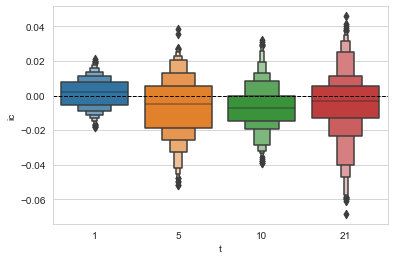

In [74]:
ax = sns.boxenplot(x='t', y='ic', data=daily_ic_avg)
ax.axhline(0, ls='--', lw=1, c='k');

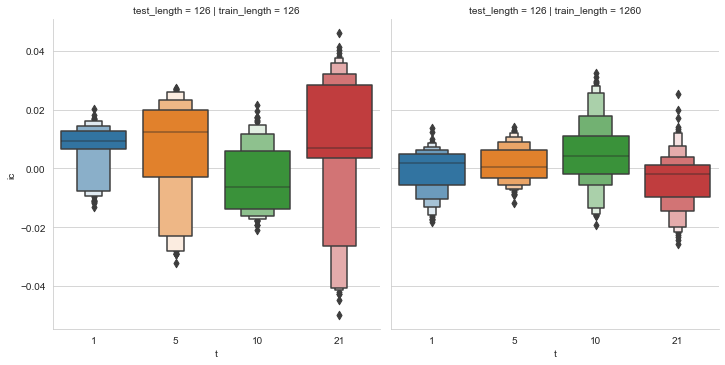

In [78]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=daily_ic_avg[(daily_ic_avg.test_length == 126)],
                kind='boxen')
g.savefig(results_path / 'daily_ic_test_126', dpi=300)

### HyperParameter Impact: Linear Regression

To get a better idea of how the various CV parameters impact the forecast quality, we can run a linear regression with the daily IC as outcome and the one-hot encoded hyperparameters as inputs:

In [86]:
lin_reg = {}
for t in [1, 21]:
    df_ = daily_ic_avg[(daily_ic_avg.t==t)&(daily_ic_avg.rounds<=250)].dropna()
    y, X = df_.ic, df_.drop(['ic', 't'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(
        columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err',
                     't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(results_path / f'lr_result_{t:02}.csv', index=False)

In [88]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith(
        'date') & (coefs.variable != 'const')]
    coefs.variable = coefs.variable.str.split('_').str[-1]

    coefs.plot(x='variable', y='coef', kind='bar', ax=ax, 
               color='none', capsize=3, yerr='error', legend=False, rot=0)    
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

    ax.annotate('Train\nLength', xy=(.09, -0.1), xytext=(.09, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Test\nLength', xy=(.23, -0.1), xytext=(.23, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=0.8', lw=1.0, color='black'))

    ax.annotate('Bagging\nFraction', xy=(.32, -0.1), xytext=(.32, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.7, lengthB=0.8', lw=1.0, color='black'))


    ax.annotate('Feature\nFraction', xy=(.44, -0.1), xytext=(.44, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=3.4, lengthB=1.0', lw=1.0, color='black'))
    

    ax.annotate('Min.\nSamples', xy=(.55, -0.1), xytext=(.55, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=1.0', lw=1.0, color='black'))    
    
    ax.annotate('Number of\nRounds', xy=(.8, -0.1), xytext=(.8, -0.2),
                xycoords='axes fraction',
                textcoords='axes fraction',
                fontsize=11, ha='center', va='bottom',
                bbox=dict(boxstyle='square', fc='white', ec='black'),
                arrowprops=dict(arrowstyle='-[, widthB=11.2, lengthB=1.0', lw=1.0, color='black'))

The below plot shows the regression coefficient values and their confidence intervals. The intercept (not shown) has a small positive value and is statistically signifant; it captures the impact of the dropped categories (the smallest value for each parameter).

For 1-day forecasts, some but not all results are insightful: 21-day testing is better, and so is `min_samples_leaf` of 500 or 1,000. 100-200 trees seem to work best, but both shorter and longer training periods are better than intermediate values.

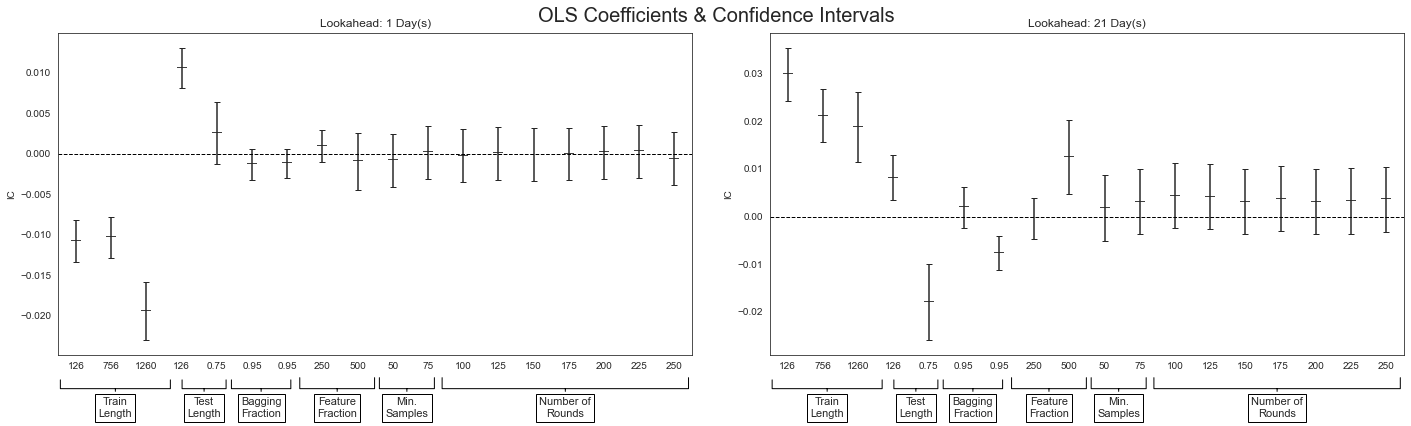

In [89]:
with sns.axes_style('white'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    axes = axes.flatten()
    for i, t in enumerate([1, 21]):
        visualize_lr_result(lin_reg[t], axes[i])
        axes[i].set_title(f'Lookahead: {t} Day(s)')
    fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.92)

### Information Coefficient: Overall

We'll also take a look at the overall IC value, which is often reported but does not necessarily match the goal of a daily trading strategy that uses the model return predictions as well as the daily IC.

In [90]:
ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_length      3600 non-null   int64  
 1   test_length       3600 non-null   int64  
 2   bagging_fraction  3600 non-null   float64
 3   feature_fraction  3600 non-null   float64
 4   min_data_in_leaf  3600 non-null   int64  
 5   t                 3600 non-null   int64  
 6   rounds            3600 non-null   int64  
 7   ic                2880 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 225.1 KB


#### Best Parameters

Directionally, and for shorter periods, similar hyperparameter settings work best (while the IC values are higher):

In [91]:
ic.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

train_length  test_length  bagging_fraction  feature_fraction  \
t                                                                        
1  125           1260          126              0.75              0.95   
   107           1260          126              0.75              0.95   
   134           1260          126              0.75              0.95   
5  1246           126          126              0.50              0.95   
   1237           126          126              0.50              0.95   
   1228           126          126              0.50              0.95   
10 1826          1260          126              0.75              0.95   
   1817          1260          126              0.75              0.95   
   1844          1260          126              0.75              0.95   
21 2755          1260          126              0.50              0.75   
   2764          1260          126              0.50              0.75   
   2773          1260          126              0.50              0.75   

         min_data_in_leaf   t  rounds        ic  
t                                                
1  125                500   1     350  0.040097  
   107                500   1     300  0.040064  
   134                500   1     375  0.039995  
5  1246               100   5     475  0.008290  
   1237               100   5     450  0.008196  
   1228               100   5     425  0.007823  
10 1826               500  10      75  0.060441  
   1817               500  10      50  0.059819  
   1844               500  10     125  0.059556  
21 2755               250  21     175  0.189525  
   2764               250  21     200  0.188815  
   2773               250  21     225  0.188796

#### Visualiztion

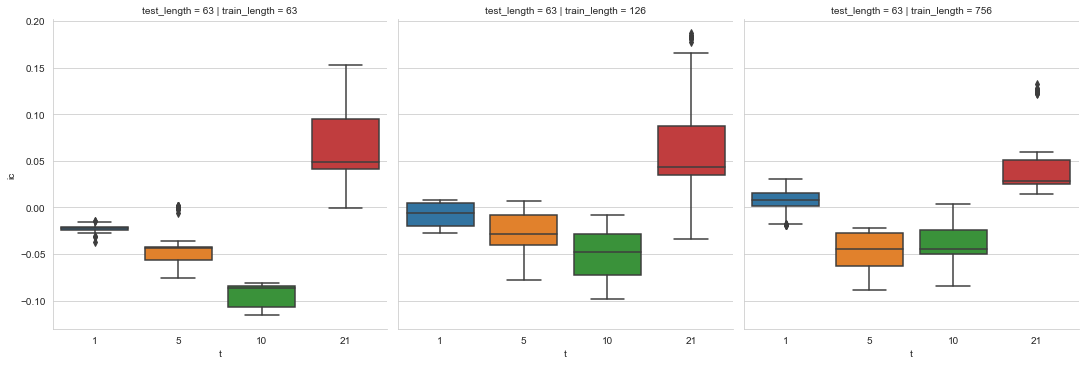

In [94]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=ic[(ic.test_length == 63) & (ic.t <= 21)],
                kind='box')

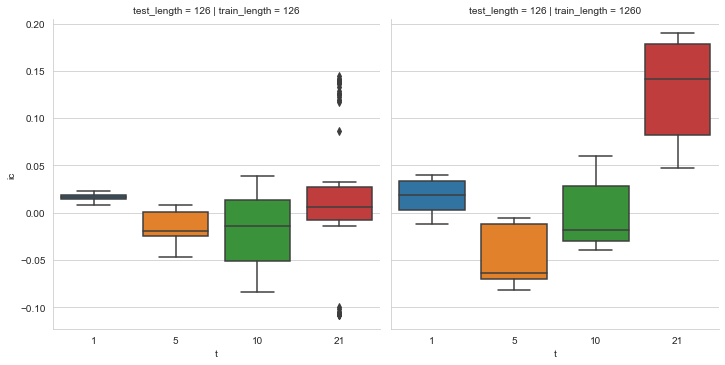

In [95]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=ic[(ic.test_length == 126) & (ic.t <= 21)],
                kind='box')

In [278]:
what = ic[(ic.t == t) &
    (ic.train_length == train_length) &
    (ic.test_length == test_length)]
what['min_data_in_leaf'].value_counts()

250    80
100    60
500    40
Name: min_data_in_leaf, dtype: int64

In [96]:
cv_params_

[(0.5, 0.75, 100),
 (0.5, 0.75, 250),
 (0.75, 0.75, 500),
 (0.5, 0.95, 500),
 (0.5, 0.95, 100),
 (0.95, 0.75, 250),
 (0.95, 0.95, 250),
 (0.95, 0.95, 100),
 (0.75, 0.95, 500)]

In [98]:
ic

,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,t,rounds,ic
0,1260,126,0.50,0.75,100,1,25,-0.004716
1,1260,126,0.50,0.75,250,1,25,0.010641
2,1260,126,0.75,0.75,500,1,25,0.030872
3,1260,126,0.50,0.95,500,1,25,0.016081
4,1260,126,0.50,0.95,100,1,25,-0.011917
...,...,...,...,...,...,...,...,...
3595,63,63,0.50,0.95,100,21,500,0.114531
3596,63,63,0.95,0.75,250,21,500,0.041806
3597,63,63,0.95,0.95,250,21,500,0.045879
3598,63,63,0.95,0.95,100,21,500,0.003460


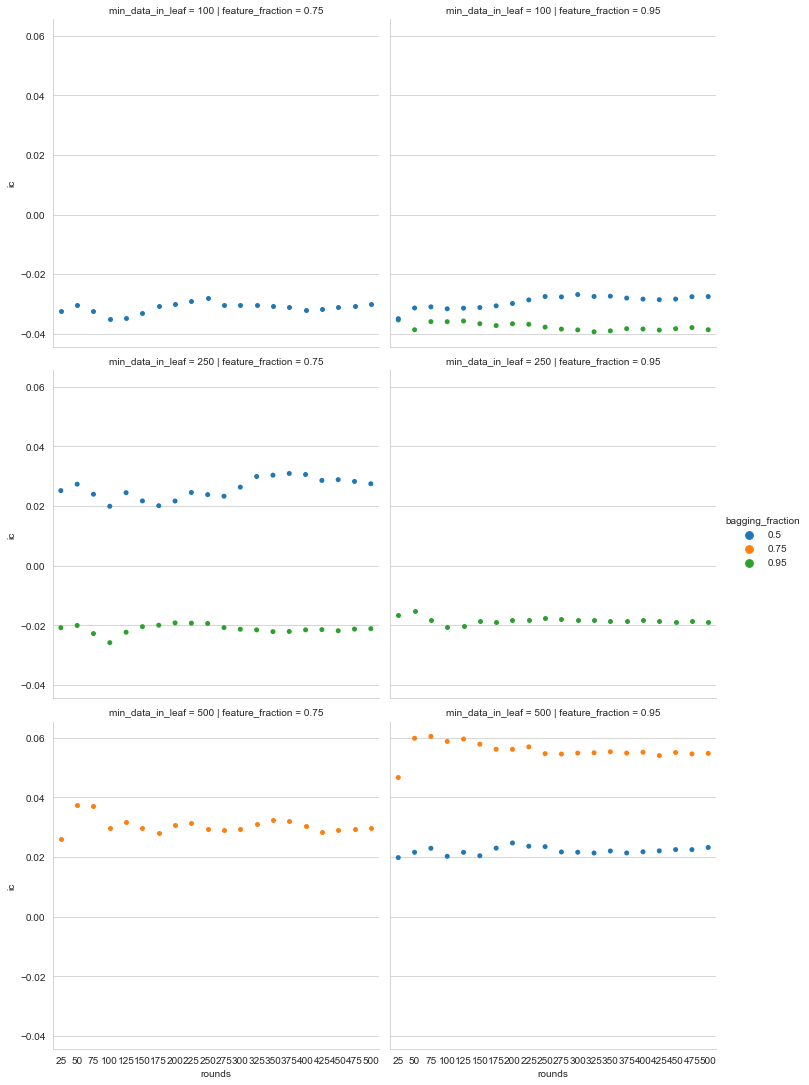

In [99]:
t = 10
train_length = 5*YEAR
test_length = 126
g = sns.catplot(x='rounds',
    y='ic',
    col='feature_fraction',
    hue='bagging_fraction',
    row='min_data_in_leaf',
    data=ic[(ic.t == t) &
            (ic.train_length == train_length) &
            (ic.test_length == test_length)],
    kind='swarm');

### Random Forest vs Linear Regression 

Let's compare the best-performing (in-sample) random forest models to our linear regression baseline:

In [101]:
lr_metrics = pd.read_csv(results_path / 'sector_lin_reg_performance.csv')
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB


In [102]:
daily_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 3600 non-null   int64  
 1   train_length      3600 non-null   int64  
 2   test_length       3600 non-null   int64  
 3   bagging_fraction  3600 non-null   float64
 4   feature_fraction  3600 non-null   float64
 5   min_data_in_leaf  3600 non-null   int64  
 6   rounds            3600 non-null   int64  
 7   ic                2880 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 225.1 KB


The results are mixed: for the shortest and longest horizons, the random forest outperforms (slightly for 1 day), while linear regression is competitive for the intermediate horizons:

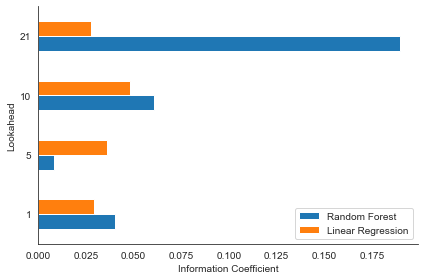

In [103]:
with sns.axes_style("white"):
    ax = (ic.groupby('t').ic.max().to_frame('Random Forest')
     .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
    ax.set_ylabel('Lookahead')
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout();

## Generate predictions

To build and evaluate a trading strategy, we create predictions for the 2018-19 period using the 10 best models that we then ensemble:

In [104]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

In [105]:
def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

In [106]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

store = Path(results_path / 'predictions.h5')

In [111]:
# for lookahead in [1, 5, 10, 21]:
num_pos = 3
lookahead = 10
for lookahead in [21]:

    print(f'\nLookahead: {lookahead:02}')
    data = (pd.read_hdf('data/sector_data.h5', 'features_data'))
    data.index.set_names('date', level=1, inplace=True)
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    data = data.loc[:, features + [label]].dropna()

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features],
                           label=data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(num_pos):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'\tPosition: {position:02}')

        n_splits = int(4 * YEAR / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            train_set = lgb_data.subset(used_indices=train_idx.tolist(),
                                        params=params).construct()
    
            model = lgb.train(params=params,
                              train_set=train_set,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)

            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))

        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        

    by_day = test_predictions.groupby(level='date')
    for position in range(num_pos):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])

    test_predictions.to_hdf(store, f'test/{lookahead:02}')


Lookahead: 21
	Position: 00
	Position: 01
	Position: 02


Train and save model

In [123]:
# for lookahead in [1, 5, 10, 21]:
num_pos = 3
lookahead = 10

data = (pd.read_hdf('data/sector_data.h5', 'features_data'))
data.index.set_names('date', level=1, inplace=True)
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()
label = f'fwd_ret_{lookahead:02}'
data = data.loc[:, features + [label]].dropna()

categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

lgb_data = lgb.Dataset(data=data[features],
                        label=data[label],
                        categorical_feature=categoricals,
                        free_raw_data=False)


params, num_boost_round = get_params(daily_ic_avg,
                                    t=lookahead
                                    )
params = params.to_dict()
params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
train_length = int(params.pop('train_length'))
test_length = int(params.pop('test_length'))
params.update(base_params)


n_splits = int(4 * YEAR / test_length)
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                            test_period_length=test_length,
                            lookahead=lookahead,
                            train_period_length=train_length)

predictions = []
loaded_predictions = []
start = time()
for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
    train_set = lgb_data.subset(used_indices=train_idx.tolist(),
                                params=params).construct()

    model = lgb.train(params=params,
                        train_set=train_set,
                        num_boost_round=num_boost_round,
                        verbose_eval=False)
    
    model.save_model(f'../saved/model_{i}.txt', num_iteration=model.best_iteration)

    test_set = data.iloc[test_idx, :]
    y_test = test_set.loc[:, label].to_frame('y_test')
    y_pred = model.predict(test_set.loc[:, model.feature_name()])
    predictions.append(y_test.assign(prediction=y_pred))

    # model = lgb.Booster(model_file=f'../saved/model_{i}.txt')
    # y_pred = model.predict(test_set.loc[:, model.feature_name()])
    # loaded_predictions.append(y_test.assign(prediction=y_pred))

In [131]:
data.index.get_level_values(0).unique()

Index(['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'], dtype='object', name='ticker')

In [140]:
from pandas import MultiIndex


idx = MultiIndex.from_product([data.index.get_level_values('ticker').unique(), [data.index.get_level_values('date')[-10]]])
data.loc[idx,:]

,,NATR,PPO,RSI,bbl,bbu,month,ret_1,ret_10,ret_21,ret_5,ret_63,ret_rel_perc_1,ret_rel_perc_10,ret_rel_perc_21,ret_rel_perc_5,ret_rel_perc_63,weekday,year,fwd_ret_10
ticker,,,,,,,,,,,,,,,,,,,,
XLB,2022-09-08,2.111305,-1.525933,49.097093,1.054458,1.007022,8,0.009715,-0.024604,-0.003240,0.019891,-0.108703,3.0,2.0,3.0,2.0,0.0,3,23,-0.091666
XLE,2022-09-08,3.017276,3.243761,49.796100,1.011708,1.018897,8,0.004342,-0.054580,0.052040,-0.023106,-0.147811,2.0,0.0,4.0,0.0,0.0,3,23,-0.037386
XLF,2022-09-08,1.996594,-1.698118,53.390591,1.051869,1.003614,8,0.017633,-0.005259,0.006206,0.030257,-0.016464,4.0,3.0,3.0,3.0,1.0,3,23,-0.073421
XLI,2022-09-08,1.718836,-1.845391,46.652102,1.027542,1.005713,8,0.002985,-0.034783,-0.017443,0.012267,-0.014768,1.0,1.0,0.0,1.0,2.0,3,23,-0.081854
XLK,2022-09-08,2.290294,-3.946409,38.499957,1.022788,1.008425,8,0.003431,-0.063679,-0.067702,-0.005323,-0.039480,1.0,0.0,0.0,0.0,1.0,3,23,-0.068084
XLP,2022-09-08,1.432884,-1.187385,42.964136,1.018791,1.011018,8,-0.002587,-0.035926,-0.016512,0.002052,-0.000955,0.0,1.0,1.0,1.0,3.0,3,23,-0.036582
XLU,2022-09-08,1.616661,-0.197476,60.821265,1.047002,1.011935,8,-0.000778,0.008506,0.025276,0.036723,0.046294,0.0,4.0,4.0,3.0,4.0,3,23,-0.057999
XLV,2022-09-08,1.606626,-2.153326,51.267507,1.047523,1.003994,8,0.017381,-0.001158,-0.015225,0.036871,-0.008660,4.0,4.0,1.0,4.0,3.0,3,23,-0.046382
XLY,2022-09-08,2.449169,-2.649050,52.119374,1.056163,1.008176,8,0.009317,-0.015972,-0.006157,0.038004,0.053380,3.0,3.0,2.0,4.0,4.0,3,23,-0.071552


In [143]:
idx[0][0]

'XLB'